# 2nd workbook

In [1]:
import pandas as pd
import numpy as np
import os 
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from importlib import reload

In [4]:
import wrangle as wr
import summaries as su
import model as m

### acquire .py

In [210]:
import pandas as pd
import numpy as np
import os

########### GLOBAL VARIABLES ###########


######## ACQUIRE FUNCTIONS #############

import pandas as pd
import numpy as np
import os

########### GLOBAL VARIABLES ###########


######## ACQUIRE FUNCTIONS #############

def acquire_data() -> pd.DataFrame:
    '''
    Reads the data from the csv file. 
    Filters data by the Vendor Name (Cisco)
    Renames columns by making them lower case replacing white space with underscore
    Removes columns where all values are NULL
    Saves the data into data.pickle file.
    Next interation reads the data from the saved file
    Returns: pandas DataFrame
    '''
    filename = 'data/data.pickle'
    filename_csv = 'data/OFFICIAL_DIR_Cooperative_Contract_Sales_Data___Fiscal_2010_To_Present.csv'
    if os.path.isfile(filename):
        # read the filtered data  
        df = pd.read_pickle(filename)
        return df
    # if not available, go to the file downloaded from https://data.texas.gov/
    # the full link to the site available in the Readme file
    else:
        try:
            # read the csv file with the data of all companies
            df1 = pd.read_csv(filename_csv, low_memory=False)
            # filter by Vendor Name is Cisco 
            df = df1[df1["Vendor Name"].str.contains('Cisco')].copy()
            # rename columns into programming friendly format
            # to lower case, white spaces replaced by underscore
            df.columns = df.columns.str.lower().str.replace(' ', '_')
            # drop the columns where all values are NULL
            df.drop(['staffing_contractor_name',
                'staffing_technology', 'staffing_title', 'staffing_level',
                'staffing_technology_type', 'staffing_start_date',
                'staffing_acquistion_type'], axis=1, inplace=True)
            # save the file
            pd.to_pickle(df, filepath_or_buffer=filename)
            return df
        except FileNotFoundError:
            # if file not found print:
            print('The file doesn\'t exist. Please, download it from the link provided in the Readme file')  

def basic_clean(df:pd.DataFrame, start2018=False) -> pd.DataFrame:
    '''
    Remove unneeded columns
    Create a copy of order date
    Changes dates type
    Sets order date as an index
    Parameters:
        df: pandas data frame
    Returns:
        cleaned data frame
    '''
    # list of columns to drop
    drop_columns = ['fiscal_year',
     'rfo_description',
     'rfo_number',
     'contract_number',
     'customer_contact',
     'customer_address',
     'customer_state',
     # 'customer_zip',
     'vendor_name',
     'vendor_contact',
     'vendor_hub_type',
     'vendor_address',
     'vendor_state',
     'vendor_city',
     'vendor_zip',
     'reseller_hub_type',
     'reseller_address',
     'reseller_state',
     'reseller_zip',
     'reseller_phone',
     'report_received_month',
     'brand_name',
     'purchase_month',
     'invoice_number',
     'dir_contract_mgr',
     'contract_type',
     'contract_subtype',
     'contract_start_date',
     'contract_end_date',
     'contract_termination_date',
     'sales_fact_number']

    df = df.drop(columns = drop_columns, axis=1)
    # create a copy for the shipped date
    df['order_date_copy'] = df.order_date

    # convert order date and shpping date to datetime
    df.order_date = pd.to_datetime(df.order_date)
    df.shipped_date = pd.to_datetime(df.shipped_date)
    df.order_date_copy = pd.to_datetime(df.order_date_copy)
    
    
    df = drop2017_and_move2016_up(df)
    
    # save the shipped date as index
    df = df.set_index('order_date').sort_index()

    if start2018:
    # data doesn't have enough info about 2017, so we starts from 2018
        df = df.loc['2018':]
    else:
        # keep all but drop 2017
        df = df.loc["2014":]
    return df



def add_date_features(df):
    '''
    Add features based on the date:
    year, month, week number, week day in numerical and human readable values
    
    Parameters:
        df: pandas data frame with date as an index
    Return:
        df: pandas data frame with features added
    '''
    # numerical features
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['day_of_week'] = df.index.day_of_week
    df['day_of_year'] = df.index.day_of_year
    # month and day human readable
    df['month_name'] = df.index.month_name()
    df['day_name'] = df.index.day_name()
    
    return df

def change_customer_type(df):
    '''
    Replace low value count values with 'Other'
    Returns data frame with replaced values in customer type
    '''
    # remove 30 rows with the sales out of Texas
    df = df[df.customer_type != 'Out of State'].copy()
    # make assistance org other
    df.customer_type.replace({'Assistance Org':'Other'},inplace=True)
    
    return df

def change_column_order(df):
    '''
    change the order of columns
    '''
    columns_order = ['customer_name', 
                     'customer_type', 
                     'customer_city',
                     'reseller_name', 
                     'reseller_city',
                     'customer_zip',
                     'order_quantity', 
                     'unit_price',
                     'po_number', 
                     'shipped_date', 
                     'order_date_copy',
                     'month_name', 
                     'day_name',
                     'year',
                     'quarter',
                     'month', 
                     'week',
                     'day_of_week', 
                     'day_of_year',
                     'purchase_amount']
    return df[columns_order]

def get_clean_data(start2018=False):
    '''
    combines all functions from above
    '''
    df = acquire_data()
    df = basic_clean(df, start2018=start2018)
    df = add_date_features(df)
    df = change_customer_type(df)
    df = change_column_order(df)

    return df


def split_data(df, explore=True):
    '''
    splits the data frame based on date
    '''
    if explore:
        train = df.loc[:'2021']
        test = df.loc['2022']
        return train, test
    else:
        return df

In [215]:
df = get_clean_data(start2018=True)

In [240]:
df.groupby(lambda x: x.year).size()

order_date
2018    55843
2019    63452
2020    66299
2021    49931
2022    26361
dtype: int64

In [216]:
# 2018 + data frame
df.shape

(261886, 20)

In [217]:
df["2018":].shape

(261886, 20)

In [231]:
df['2018'].shape

(55843, 20)

In [230]:
df['2019'].shape

(63452, 20)

In [232]:
df['2020'].shape

(66299, 20)

In [233]:
df['2021'].shape

(49931, 20)

In [234]:
df['2022'].shape

(26361, 20)

In [218]:
# from 2014 and on
df_all = get_clean_data(start2018=False)

In [220]:
df_all.shape

(372837, 20)

In [239]:
df_all['2022'].shape

(26361, 20)

In [221]:
261886-372837

-110951

In [192]:
372837-321680

51157

In [191]:
df.shape

(321680, 20)

### how to manage missing year 2017...

In [92]:
df['2018'].max(), df['2018'].min()

(customer_name      Zephyr Independent School District
 customer_type                            State Agency
 customer_city                                  Zephyr
 reseller_name                             Zones, Inc.
 order_quantity                           1,048,103.48
 unit_price                               1,130,443.51
 shipped_date                      2022-11-30 00:00:00
 order_date_copy                   2018-12-31 00:00:00
 month_name                                  September
 day_name                                    Wednesday
 year                                             2018
 quarter                                             4
 month                                              12
 week                                               52
 day_of_week                                         6
 day_of_year                                       365
 purchase_amount                          2,028,000.00
 dtype: object,
 customer_name      Abilene Independent School Di

Original 2016 max----------------------------
```python
(customer_name      Zapata County Public Library
 customer_type                      State Agency
 customer_city                            Zapata
 reseller_name                       Zones, Inc.
 reseller_city                      Vernon Hills
 order_quantity                       599,994.00
 unit_price                         1,346,270.33
 po_number                          ewscada09/16
 shipped_date                2020-04-30 00:00:00
 order_date_copy             2016-12-31 00:00:00
 month_name                            September
 day_name                              Wednesday
 year                                       2016
 quarter                                       4
 month                                        12
 week                                         53
 day_of_week                                   6
 day_of_year                                 366
 purchase_amount                    1,346,270.33
 dtype: object,
 
 
 Original 2016 min -----------------------------
 customer_name      Abilene Independent School District
 customer_type                                Higher Ed
 customer_city                                  Abilene
 reseller_name                               AT&T Corp.
 reseller_city                                  Addison
 order_quantity                               -9,000.00
 unit_price                                        0.00
 po_number                                   0000004241
 shipped_date                       2015-01-05 00:00:00
 order_date_copy                    2016-01-01 00:00:00
 month_name                                       April
 day_name                                        Friday
 year                                              2016
 quarter                                              1
 month                                                1
 week                                                 1
 day_of_week                                          0
 day_of_year                                          1
 purchase_amount                             -61,140.60
 dtype: object)
```

2018 max -------------------
``` python 
(customer_name      Zephyr Independent School District
 customer_type                            State Agency
 customer_city                                  Zephyr
 reseller_name                             Zones, Inc.
 order_quantity                           1,048,103.48
 unit_price                               1,130,443.51
 shipped_date                      2022-11-30 00:00:00
 order_date_copy                   2018-12-31 00:00:00
 month_name                                  September
 day_name                                    Wednesday
 year                                             2018
 quarter                                             4
 month                                              12
 week                                               52
 day_of_week                                         6
 day_of_year                                       365
 purchase_amount                          2,028,000.00
 dtype: object,
 
 2018 min ------------------------------------------
 customer_name      Abilene Independent School District
 customer_type                                Higher Ed
 customer_city                                   AUSTIN
 reseller_name                               AT&T Corp.
 order_quantity                             -799,867.61
 unit_price                                        0.00
 shipped_date                       2018-01-02 00:00:00
 order_date_copy                    2018-01-02 00:00:00
 month_name                                       April
 day_name                                        Friday
 year                                              2018
 quarter                                              1
 month                                                1
 week                                                 1
 day_of_week                                          0
 day_of_year                                          2
 purchase_amount                            -468,750.00
 dtype: object)
```

In [98]:
df3 = pd.read_pickle('data/data.pickle')

In [145]:
# a total of 5656 observations have a year of 2017
shape_2017 = df3[df3.order_date.dt.year==2017].shape[0]
df3[df3.order_date.dt.year==2017].shape


(5656, 42)

In [179]:
final_df.order_date.dt.year.value_counts().sort_values()

2015    20596
2022    26361
2016    39200
2021    49931
2017    51161
2018    55867
2019    63452
2020    66299
Name: order_date, dtype: int64

```python
Original
2014    20596 
2022    26361
2015    39198 two got added here from 2015 to 2016
2021    49931
2016    51157 four got added  her from 2016 to 2017
2018    55843  24 got added here? from 2018 to 2018
2019    63452
2020    66299
```

In [178]:
df3.order_date.dt.year.value_counts().sort_values()

2017     5656
2014    20596
2022    26361
2015    39200
2021    49931
2016    51161
2018    55867
2019    63452
2020    66299
Name: order_date, dtype: int64

In [129]:
temp_df = df3[(df3.order_date.dt.year==2014)|(df3.order_date.dt.year==2015)|(df3.order_date.dt.year==2016)]

In [160]:
temp_df.shape[0]==51161+39200+20596

True

In [138]:
#temp_df

In [135]:
temp2 = df3[(df3.order_date.dt.year==2018)|(df3.order_date.dt.year==2019)|(df3.order_date.dt.year==2020)|(df3.order_date.dt.year==2021)|(df3.order_date.dt.year==2022)]

In [159]:
temp2.shape[0]==66299+63452+55867+49931+26361

True

In [141]:
final_df = pd.concat([temp_df, temp2], axis =0)

In [147]:
final_shape = final_df.shape[0]
final_df.shape

(372867, 42)

In [148]:
df.shape[0] - shape_2017==final_df.shape[0]

False

In [152]:
372837-372867

-30

In [149]:
final_shape

372867

In [165]:
temp_df['order_date'] = temp_df['order_date'] +  pd.offsets.DateOffset(years=1)

In [167]:
#temp_df

In [168]:
final_df = pd.concat([temp_df, temp2], axis =0)

In [169]:
final_shape = final_df.shape[0]
final_df.shape

(372867, 42)

### create definition to handle missing year

In [203]:
def drop2017_and_move2016_up(df):
    '''
    This function drops missing year 2017 to combine data with 2018+ dataframe. This is done by creating a temporary
    dataframe and adding a year to years 2014-2016 to creates a seam between 2016 and 2018. 
    return dataframe with new years for temp_df
    '''
    temp_df = df[(df.order_date.dt.year==2014)|(df.order_date.dt.year==2015)|(df.order_date.dt.year==2016)]
    temp_df['order_date'] = temp_df['order_date'] +  pd.offsets.DateOffset(years=1)
    
    temp2 = df[(df.order_date.dt.year==2018)|(df.order_date.dt.year==2019)|(df.order_date.dt.year==2020)|(df.order_date.dt.year==2021)|(df.order_date.dt.year==2022)]
    final_df = pd.concat([temp_df, temp2], axis =0)
    
    return final_df

In [241]:
# split data for modeling

In [6]:
train, test = wr.split_data(df)

In [7]:
train

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,month_name,day_name,year,quarter,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,283.25,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"4,532.00"
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,178.75,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"2,860.00"
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,11.69,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,187.04
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,26.81,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,428.96
2018-01-02,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Insight Public Sector, Inc.",Tempe,"78,586.00",1.00,63.36,191971,2018-02-03,2018-01-02,January,Tuesday,2018,1,1,1,1,2,63.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,Carrollton-Farmers Branch Independent School D...,K-12,Carrollton,Pivot Technology Services Corporation dba Comp...,Norcross,75011,8.00,404.29,199594,2022-02-02,2021-12-30,December,Thursday,2021,4,12,52,3,364,"3,234.32"
2021-12-30,City of Mercedes,Local Government,Mercedes,"Insight Public Sector, Inc.",Tempe,78570,3.00,165.00,22-67327,2022-07-31,2021-12-30,December,Thursday,2021,4,12,52,3,364,495.00
2021-12-30,City of Mercedes,Local Government,Mercedes,"Insight Public Sector, Inc.",Tempe,"78,570.00",4.00,165.00,22-67327,2022-04-30,2021-12-30,December,Thursday,2021,4,12,52,3,364,660.00


In [69]:
# take a look at value counts
columns = df.columns.to_list()
for i in columns:
    print(f'--------{i}-------')
    print(df[i].value_counts())
    print('___________________')
    

--------customer_name-------
Texas Health and Human Services Commission      29289
Texas Department of Information Resources       21602
Brownsville Independent School District         12621
City of Austin                                  11930
Harris County                                    8010
                                                ...  
Whitharral Independent School District              1
San Jacinto College District                        1
Hardin-Jefferson Independent School District        1
Coahoma Independent School District                 1
City of Odessa                                      1
Name: customer_name, Length: 1292, dtype: int64
___________________
--------customer_type-------
K-12                122230
Local Government    118033
State Agency         72499
Higher Ed            59454
Other                  621
Name: customer_type, dtype: int64
___________________
--------customer_city-------
Austin            95201
San Antonio       25756
Houston       

In [9]:
def create_customertype_subgroups(train):
    
    types = train[['purchase_amount','customer_type']]
    k_12= types[types["customer_type"]=='K-12']
    local_gov = types[types["customer_type"]=='Local Government']
    state_agency = types[types["customer_type"]=='State Agency']
    higher_ed = types[types["customer_type"]=='Higher Ed']
    other = types[types['customer_type']=='Other']
    
    return k_12, local_gov, state_agency, higher_ed, other

In [10]:
k_12, local_gov, state_agency, higher_ed, other = create_customertype_subgroups(train)

In [11]:
k_12

,purchase_amount,customer_type
order_date,,
2018-01-02,"4,532.00",K-12
2018-01-02,"2,860.00",K-12
2018-01-02,187.04,K-12
2018-01-02,428.96,K-12
2018-01-02,63.36,K-12
...,...,...
2021-12-29,"14,625.00",K-12
2021-12-29,"4,381.40",K-12
2021-12-29,"13,845.00",K-12


# Explore subgroups

In [12]:
df

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,month_name,day_name,year,quarter,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,283.25,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"4,532.00"
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,178.75,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,"2,860.00"
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,11.69,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,187.04
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,"78,370.00",16.00,26.81,173494,2018-01-11,2018-01-02,January,Tuesday,2018,1,1,1,1,2,428.96
2018-01-02,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Insight Public Sector, Inc.",Tempe,"78,586.00",1.00,63.36,191971,2018-02-03,2018-01-02,January,Tuesday,2018,1,1,1,1,2,63.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,Harlingen Waterworks System,Local Government,HARLINGEN,"SHI Government Solutions, Inc.",Austin,78551,2.00,"1,234.62",232760,2022-11-29,2022-11-25,November,Friday,2022,4,11,47,4,329,"2,469.24"
2022-11-28,City of San Antonio,Local Government,San Antonio,Great South Texas Corporation dba Computer Sol...,San Antonio,78283,2.00,215.00,8000437865,2022-11-29,2022-11-28,November,Monday,2022,4,11,48,0,332,430.00
2022-11-28,City of Duncanville,Local Government,Duncanville,"SHI Government Solutions, Inc.",Austin,75116,6.00,87.63,20221128,2022-11-29,2022-11-28,November,Monday,2022,4,11,48,0,332,525.78


In [13]:
k_12.index

DatetimeIndex(['2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02',
               '2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02',
               '2018-01-02', '2018-01-02',
               ...
               '2021-12-22', '2021-12-28', '2021-12-28', '2021-12-28',
               '2021-12-28', '2021-12-29', '2021-12-29', '2021-12-29',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='order_date', length=81173, freq=None)

In [14]:
k_12.isnull().sum()

purchase_amount    0
customer_type      0
dtype: int64

In [15]:
k_12.isnull().sum()

purchase_amount    0
customer_type      0
dtype: int64

In [16]:
def get_timeseries_plus(df):
    print(pd.plotting.autocorrelation_plot(df.resample('W').mean()))
    print (df.groupby([df.index.year, df.index.month]).mean().unstack(0).plot())
    print(df.groupby([df.index.year, df.index.day]).mean().unstack(0).plot())
    y = df.resample('W').mean()

    result = sm.tsa.seasonal_decompose(y)
    print(result.plot())

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
Figure(792x288)


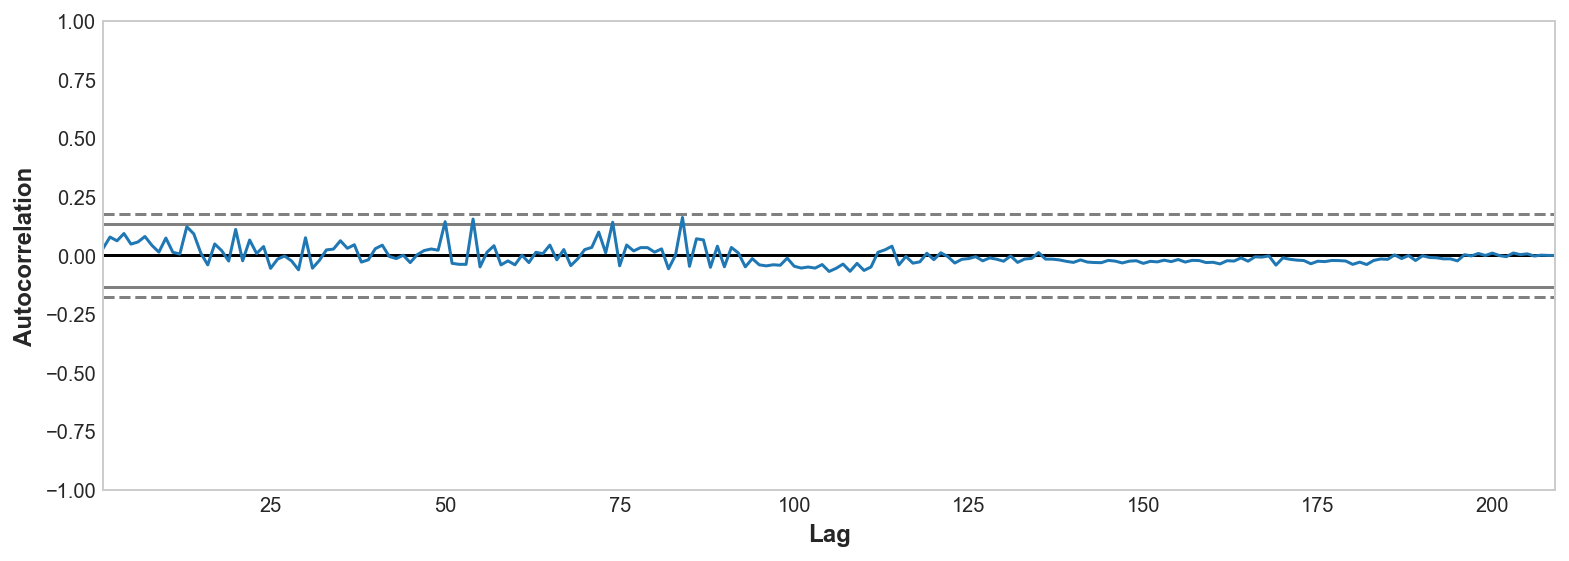

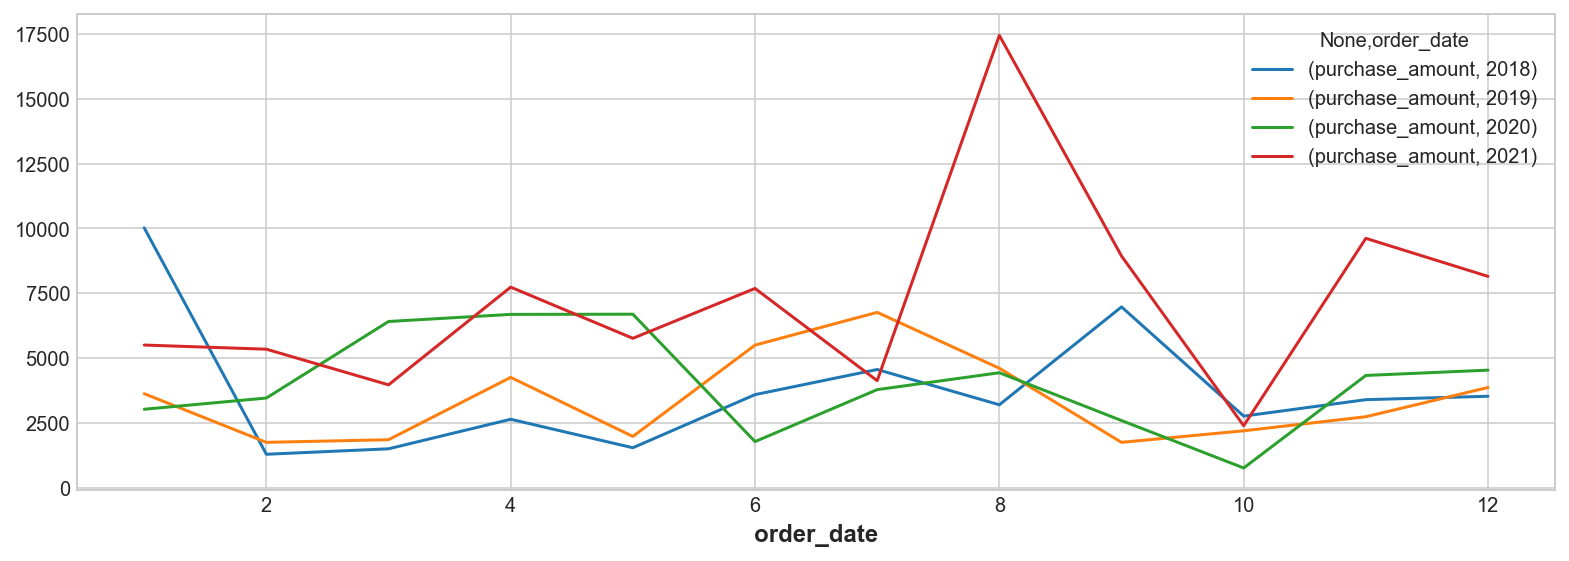

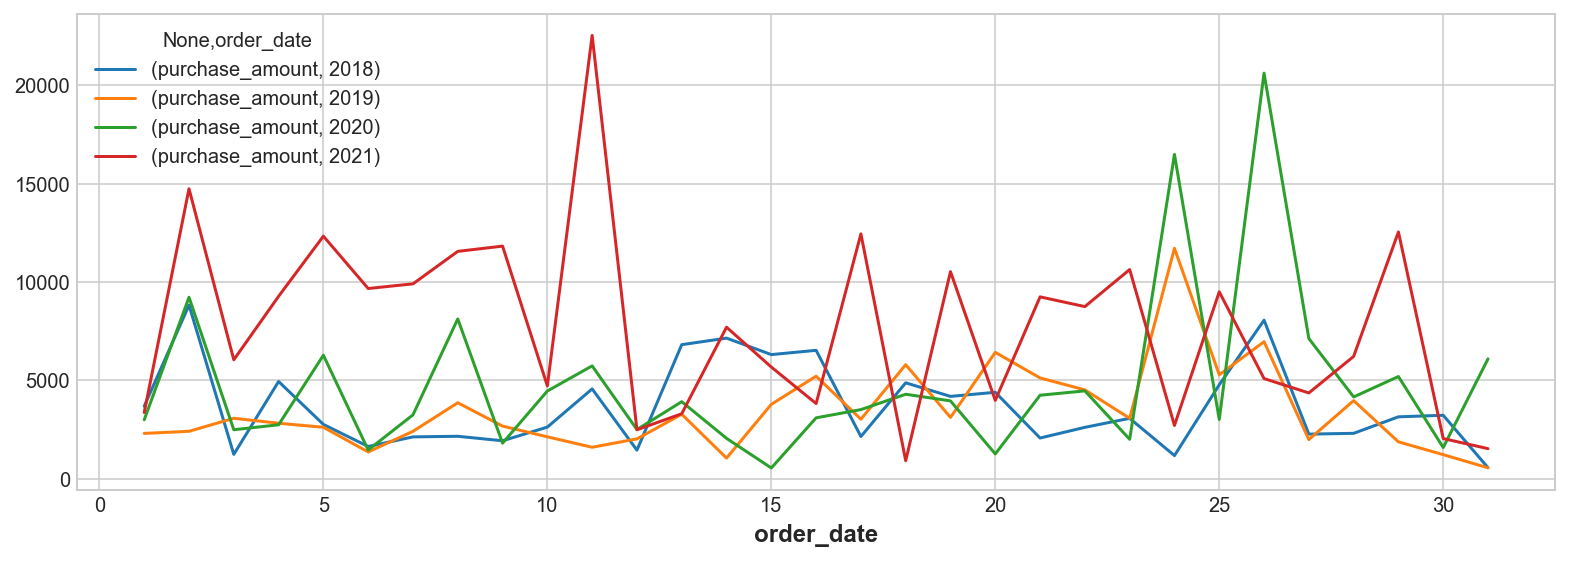

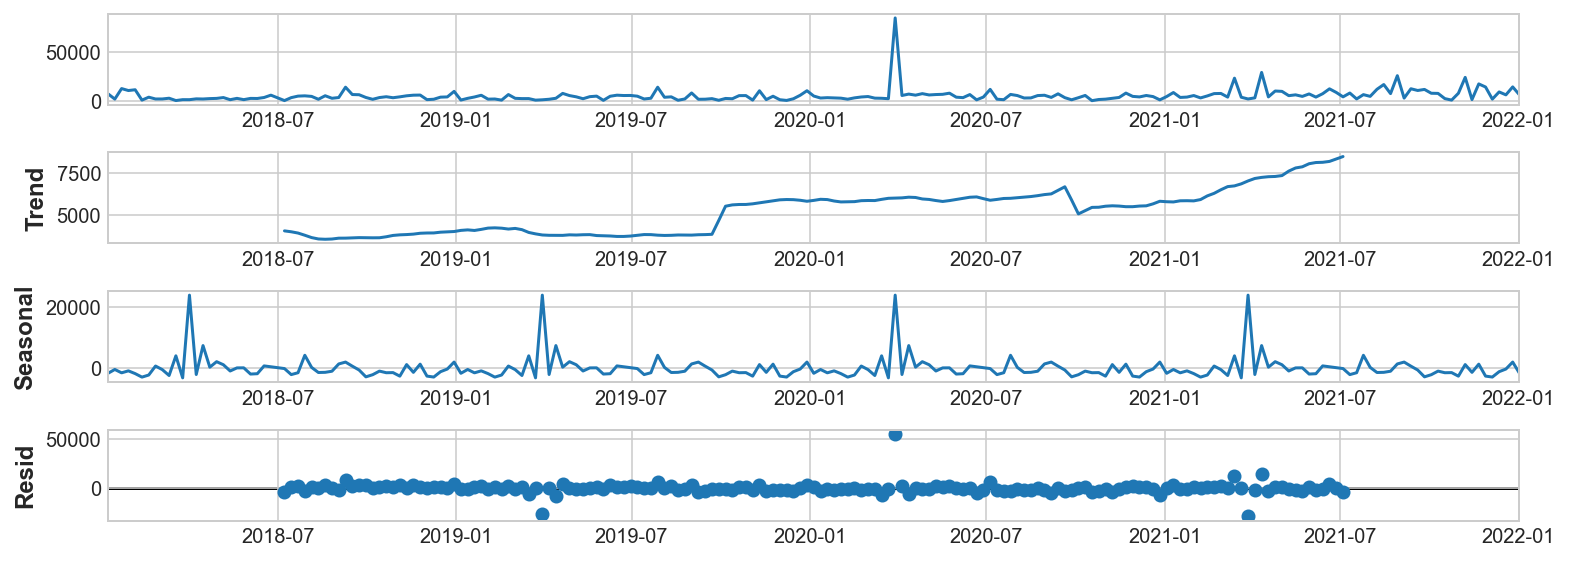

In [17]:
get_timeseries_plus(k_12)

In [18]:
su.get_customer_type_summary(train)

,total_purchase_amount,min_purchase_amount,max_purchase amount,average_purchase_amount,min_order_date,max_order_date,min_shipping_date,max_shipping_date
customer_type,,,,,,,,
Higher Ed,"200,305,221.56","-200,583.00","1,001,346.40","4,967.27",2018-01-02,2021-12-30,2018-01-05,2022-11-30
K-12,"298,079,471.56","-696,740.88","3,723,000.00","3,672.15",2018-01-02,2021-12-30,2018-01-02,2022-11-30
Local Government,"284,544,512.41","-468,750.00","2,028,000.00","3,937.73",2018-01-02,2021-12-31,2018-01-02,2022-11-30
Other,"1,918,628.88",-475.14,"101,420.58","3,579.53",2018-01-11,2021-12-22,2018-01-12,2022-02-28
State Agency,"171,212,339.55","-239,650.46","1,130,443.51","4,152.62",2018-01-05,2021-12-30,2018-01-11,2022-11-15


### time series at a glance

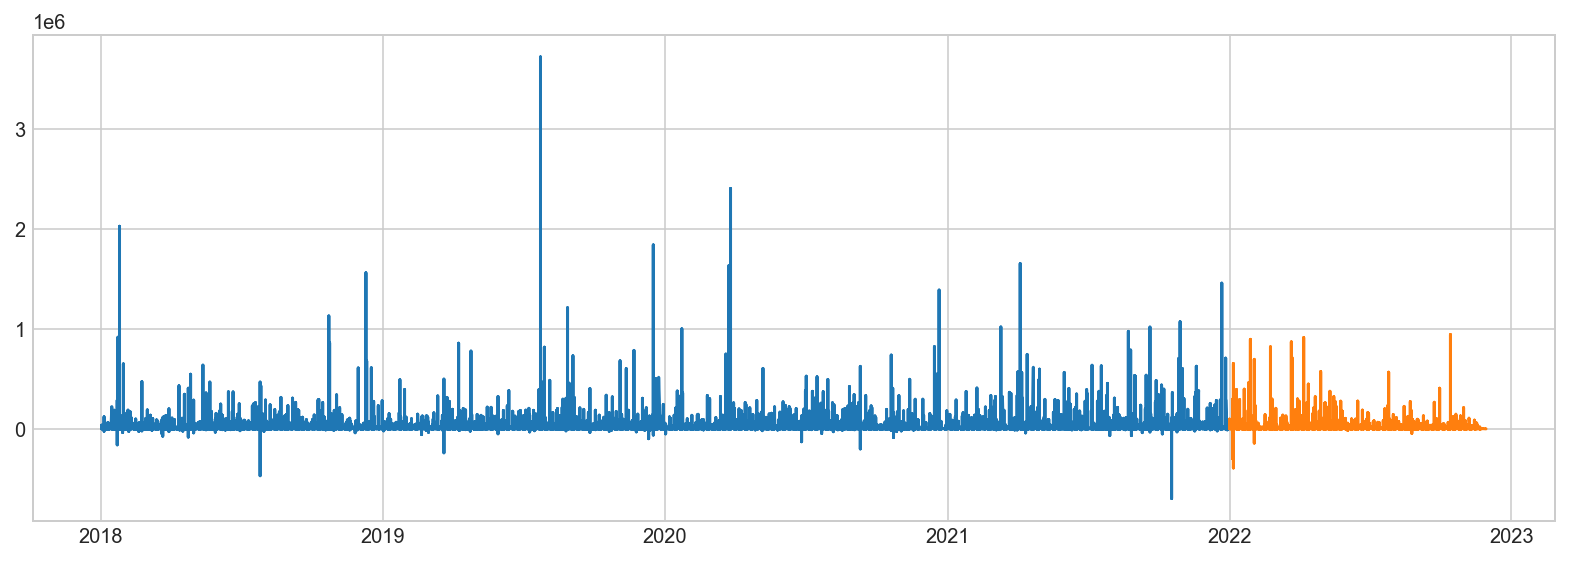

In [19]:
plt.plot(train.index, train.purchase_amount)
plt.plot(test.index, test.purchase_amount)

### distribution of variables

In [20]:
def distribution( df, var):
    ''' distribution takes in a dataframe and variable and returns a histoplot 
    that  display the distirbution of the variable'''
    # use histplot
    sns.histplot(df[var])
    #show plot
    plt.show();


In [21]:
 train.columns.to_list()

['customer_name',
 'customer_type',
 'customer_city',
 'reseller_name',
 'reseller_city',
 'customer_zip',
 'order_quantity',
 'unit_price',
 'po_number',
 'shipped_date',
 'order_date_copy',
 'month_name',
 'day_name',
 'year',
 'quarter',
 'month',
 'week',
 'day_of_week',
 'day_of_year',
 'purchase_amount']

# Average purchased sales/order quantity by month and sum by month

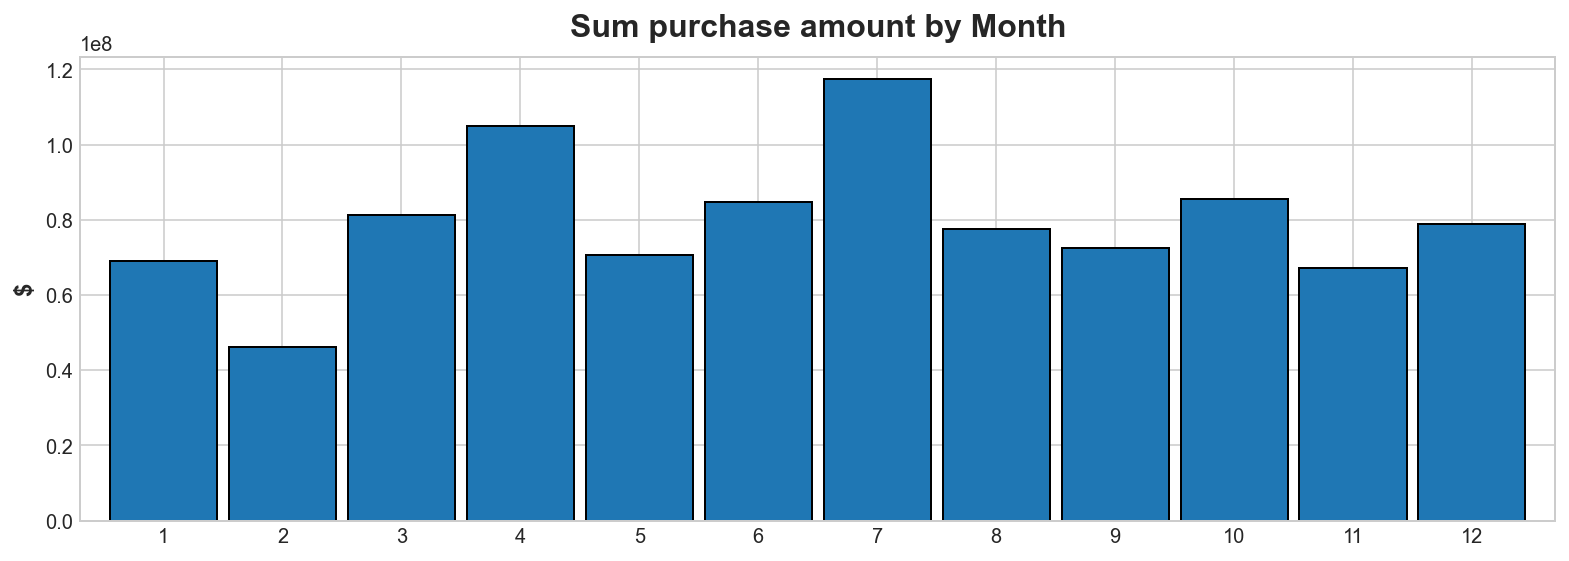

In [22]:
ax = train.groupby(train.month).purchase_amount.sum().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Sum purchase amount by Month', xlabel='', ylabel='$')
plt.show()

### for total sales the month of July seems to be the largest next largest is to April

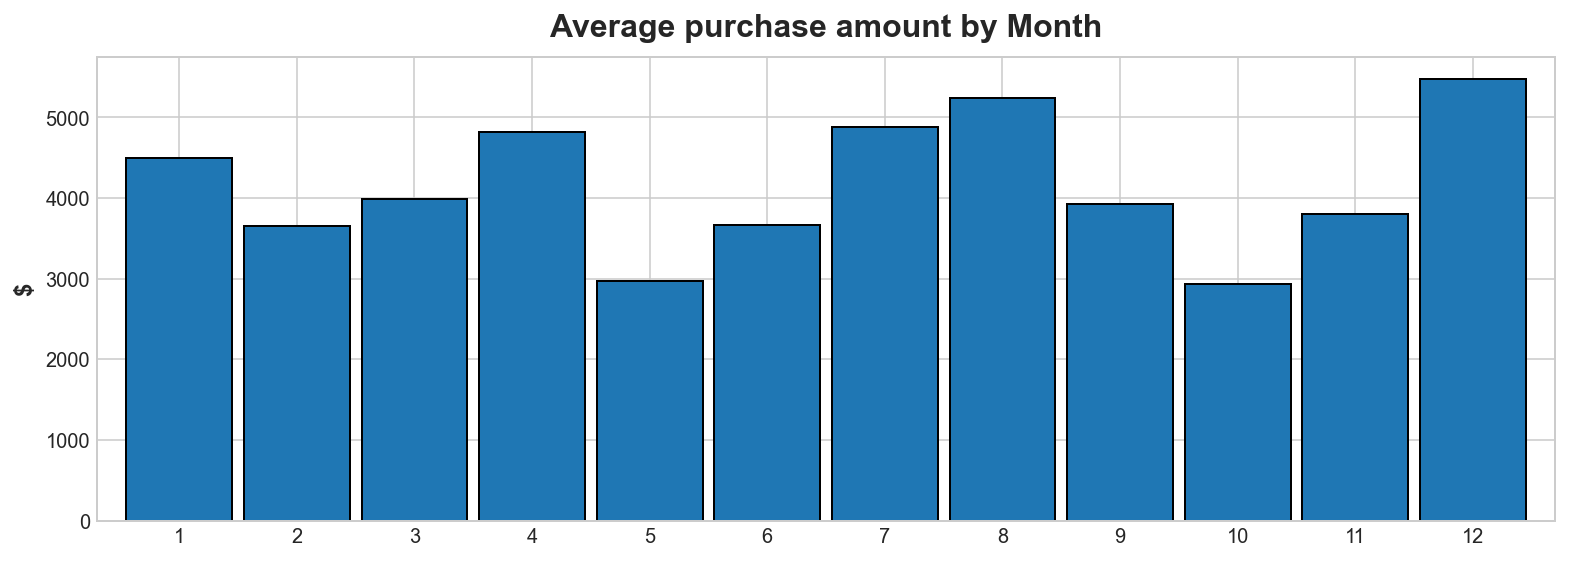

In [23]:
ax = train.groupby(train.month).purchase_amount.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average purchase amount by Month', xlabel='', ylabel='$')
plt.show()

### for average sales december seems to have the most

In [24]:
train[['purchase_amount','month']].groupby('month').describe()

purchase_amount                                                        \
                count     mean       std         min    25%    50%      75%   
month                                                                         
1           15,353.00 4,501.10 26,726.87 -159,904.75 114.00 464.10 2,180.37   
2           12,622.00 3,659.97 14,038.05  -56,708.45 127.50 462.50 2,297.34   
3           20,383.00 3,993.43 31,228.95 -239,650.46 140.01 693.00 1,759.50   
4           21,777.00 4,815.56 25,708.28  -81,758.97  57.00 415.02 2,198.63   
5           23,786.00 2,969.91 13,080.03  -49,500.00 160.20 424.80 1,448.73   
6           23,142.00 3,667.21 16,114.96 -128,760.00 160.09 594.09 1,429.42   
7           24,050.00 4,885.26 33,522.87 -468,750.00 160.20 442.24 1,982.68   
8           14,771.00 5,246.79 24,767.81  -66,871.00 124.10 684.00 2,867.41   
9           18,491.00 3,922.11 20,330.56 -200,583.00  15.41 239.98 1,489.65   
10          29,116.00 2,936.35 19,064.97 -696,740.88  27.75 325.00 1,032.17   
11          17,629.00 3,803.82 20,459.49  -38,841.19 160.20 554.45 1,590.60   
12          14,405.00 5,478.41 34,613.85  -98,143.46  82.66 646.00 3,396.00   

                    
               max  
month               
1     2,028,000.00  
2       472,950.00  
3     2,406,064.50  
4     1,654,773.44  
5       638,297.40  
6       565,171.52  
7     3,723,000.00  
8     1,212,924.79  
9     1,019,084.75  
10    1,130,443.51  
11      785,353.20  
12    1,841,400.00

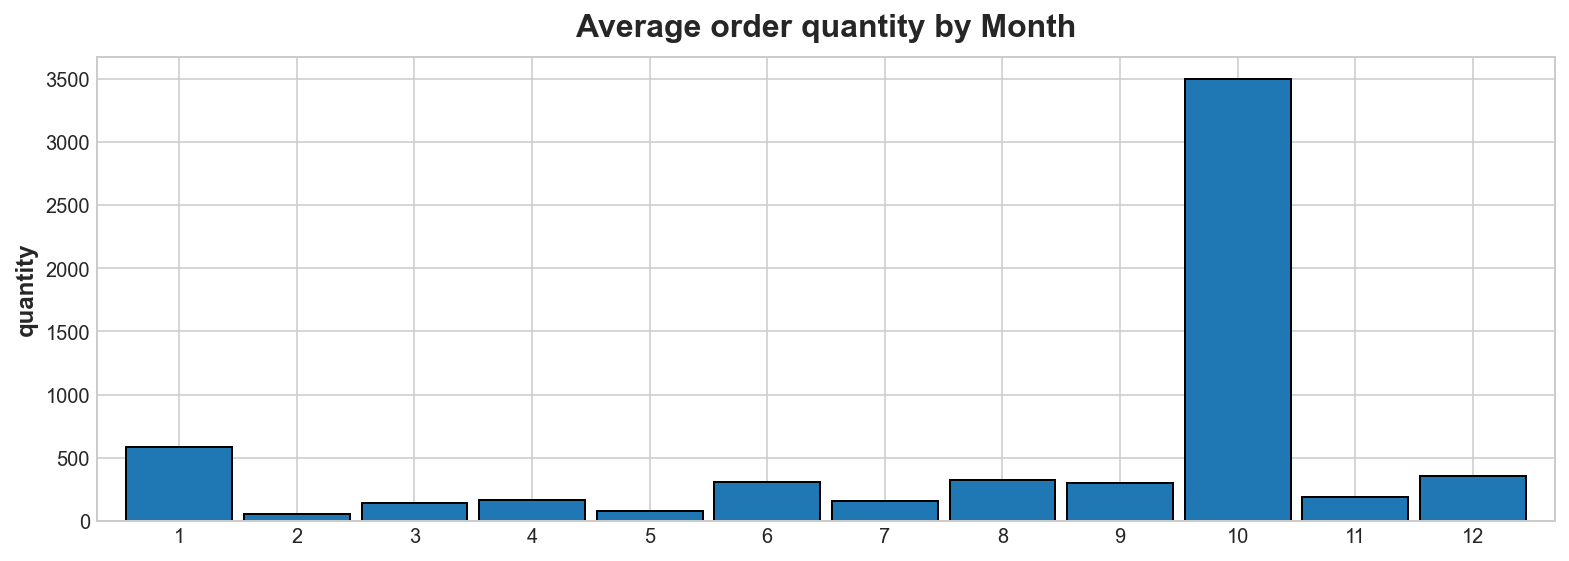

In [25]:
ax = train.groupby(train.month).order_quantity.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average order quantity by Month', xlabel='', ylabel='quantity')
plt.show()

### October has  a huge spike in order quantity

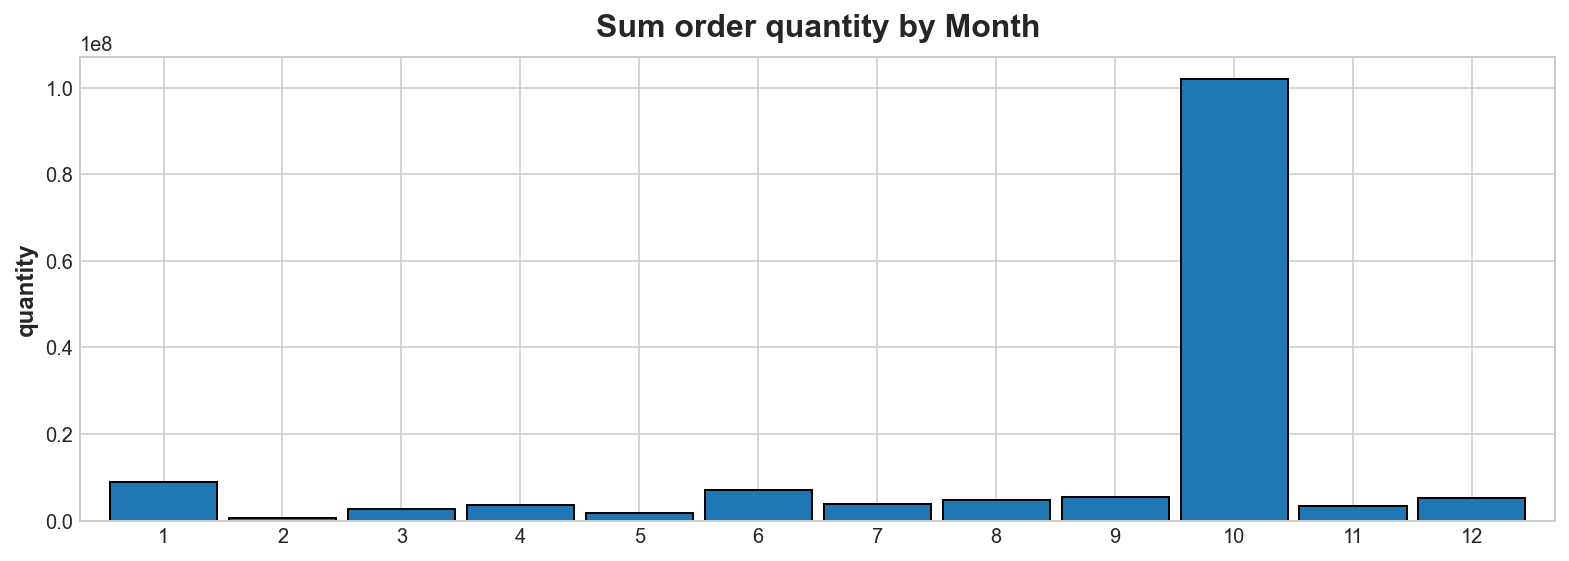

In [26]:
ax = train.groupby(train.month).order_quantity.sum().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Sum order quantity by Month', xlabel='', ylabel='quantity')
plt.show()

In [27]:
train[['order_quantity','month']].groupby('month').describe()

order_quantity                                                   \
               count     mean        std           min  25%  50%  75%   
month                                                                   
1          15,353.00   582.98  32,133.43       -864.35 1.00 1.00 3.00   
2          12,622.00    53.32   1,413.36    -59,619.00 1.00 1.00 3.00   
3          20,383.00   136.22   2,854.13       -185.00 1.00 1.00 3.00   
4          21,777.00   166.88   3,177.14    -30,490.00 1.00 1.84 3.00   
5          23,786.00    76.32   3,294.61     -3,500.00 1.00 1.00 2.00   
6          23,142.00   302.74  13,894.78    -34,800.00 1.00 1.00 2.00   
7          24,050.00   157.93  11,171.84   -799,867.61 1.00 1.00 3.00   
8          14,771.00   320.21   9,318.62     -5,825.00 1.00 1.00 4.00   
9          18,491.00   300.60  19,334.38 -1,273,855.94 0.34 1.00 2.00   
10         29,116.00 3,503.36 551,516.31    -99,999.00 1.00 1.00 2.00   
11         17,629.00   188.10   7,428.31    -46,796.61 1.00 1.00 2.00   
12         14,405.00   356.03   7,686.24     -1,365.30 1.00 1.00 4.00   

                     
                max  
month                
1      3,767,123.29  
2         77,760.00  
3        183,296.80  
4        180,000.00  
5        468,750.00  
6      1,216,118.75  
7        799,867.61  
8        711,350.00  
9      1,273,855.94  
10    94,093,187.00  
11       884,747.26  
12       390,000.00

<AxesSubplot:xlabel='month', ylabel='purchase_amount'>

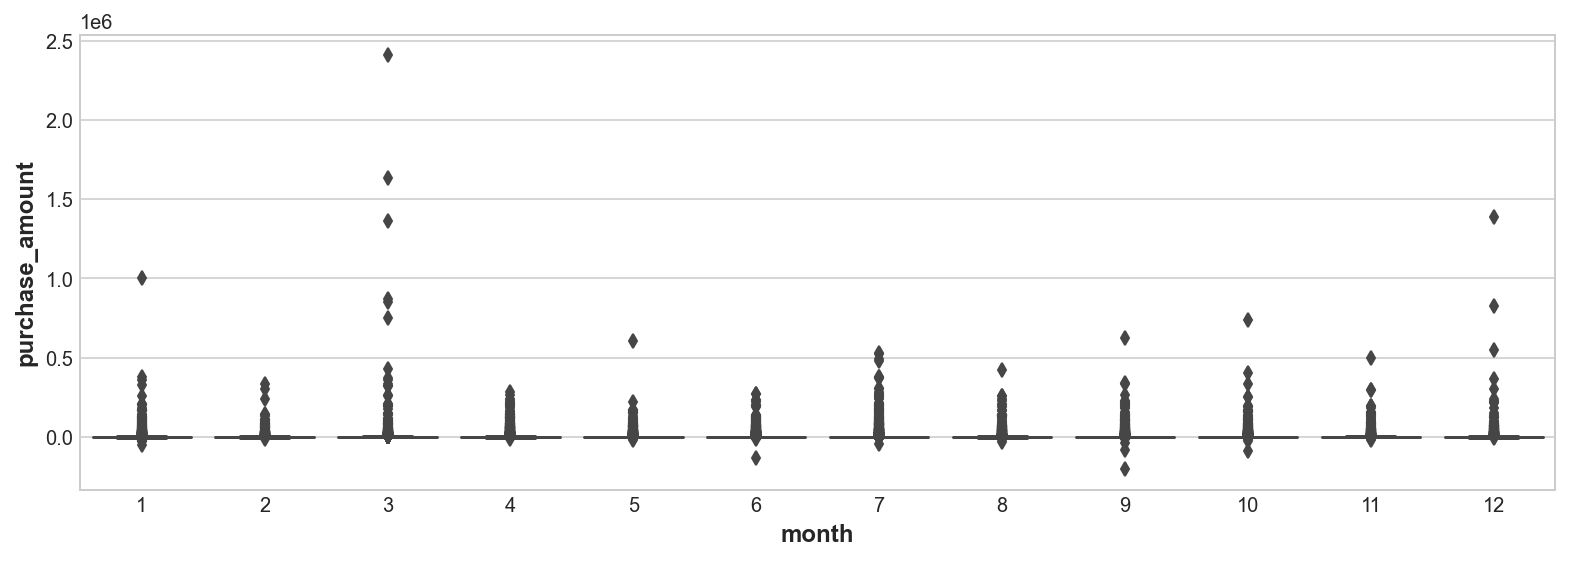

In [28]:
sns.boxplot(data = train['2020'], x = 'month', y = 'purchase_amount')

# Question look into 2017-07-24 the day with the largest sale

In [29]:
sdf = su.get_summary_df(train)

In [30]:
sdf

,customer_name,customer_type,customer_city,reseller_name,shipped_date,purchase_amount
order_date,,,,,,
2018-01-02,City of Austin,Local Government,Austin,"Netsync Network Solutions, Inc.",2018-02-14,252.00
2018-01-02,City of Euless,Local Government,Euless,CDW Government LLC,2018-01-02,"1,472.00"
2018-01-02,Conroe Independent School District,K-12,Conroe,CDW Government LLC,2018-01-02,"15,981.12"
2018-01-02,Galveston County,Local Government,Galveston,"Datavox, Inc",2018-01-31,"29,523.00"
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,2018-01-11,"8,008.00"
...,...,...,...,...,...,...
2021-12-30,Teacher Retirement System of Texas,State Agency,Austin,"Presidio Networked Solutions Group, LLC",2022-04-12,"24,850.60"
2021-12-30,Texas Juvenile Justice Department,State Agency,Austin,"Presidio Networked Solutions Group, LLC",2022-01-25,"5,910.17"
2021-12-30,The University of Texas Health Science Center ...,Higher Ed,San Antonio,"Presidio Networked Solutions Group, LLC",2022-01-14,"2,022.99"


In [31]:
sdf.loc['2019-07-24'].purchase_amount.sum()

7034384.48

In [32]:
sdf.loc['2019-07-24'].groupby('customer_type').sum()

,purchase_amount
customer_type,
Higher Ed,"436,702.13"
K-12,"4,623,390.78"
Local Government,"78,695.20"
State Agency,"1,895,596.37"


### there was a large sale done my the k-12 group

In [33]:
k_12_max = train[(train.customer_type=='K-12')&(train.order_date_copy=='2019-07-24')]

In [34]:
k_12_max.groupby('customer_name').sum()

,order_quantity,unit_price,year,quarter,month,week,day_of_week,day_of_year,purchase_amount
customer_name,,,,,,,,,
Allen Independent School District,3.00,"4,852.42",6057,9,21,90,6,615,"4,852.42"
Brownsville Independent School District,12.00,"1,737.34",12114,18,42,180,12,1230,"1,866.72"
Decatur Independent School District,1.00,10.58,2019,3,7,30,2,205,10.58
Edgewood Independent School District,7.75,390.00,4038,6,14,60,4,410,"1,511.25"
Fort Bend Independent School District,"482,299.54","388,513.08",240261,357,833,3570,238,24395,"4,126,677.13"
Luling Independent School District,126.00,67.50,2019,3,7,30,2,205,"8,505.00"
Magnolia Independent School District,1.00,192.00,2019,3,7,30,2,205,192.00
Matagorda Independent School District,4.00,"1,051.92",6057,9,21,90,6,615,"1,171.32"
Northside Independent School District,"5,605.00",469.63,6057,9,21,90,6,615,"453,266.41"


# Question: look into the day with the largest order date...right before pandemic

In [35]:
sdf2 = su.get_summary_df(train)

In [36]:
sdf2.loc['2020-01-02']

,customer_name,customer_type,customer_city,reseller_name,shipped_date,purchase_amount
order_date,,,,,,
2020-01-02,Bastrop County,Local Government,Bastrop,"SHI Government Solutions, Inc.",2020-01-03,211.00
2020-01-02,City of Baytown,Local Government,Baytown,"Presidio Networked Solutions Group, LLC",2020-01-07,"2,602.14"
2020-01-02,City of Frisco,Local Government,Frisco,"Netsync Network Solutions, Inc.",2020-01-11,"11,607.48"
2020-01-02,City of Houston,Local Government,Houston,"Netsync Network Solutions, Inc.",2020-01-11,"42,767.50"
2020-01-02,City of Lewisville,Local Government,Lewisville,"Presidio Networked Solutions Group, LLC",2020-01-03,507.38
2020-01-02,City of Round Rock,Local Government,Round Rock,"Presidio Networked Solutions Group, LLC",2020-01-06,32.59
2020-01-02,City of Wichita Falls,Local Government,Wichita Falls,CDW Government LLC,2020-01-14,"5,690.00"
2020-01-02,City of Wichita Falls,Local Government,Wichita Falls,CDW Government LLC,2020-01-17,"1,898.96"
2020-01-02,Cy-Fair Volunteer Fire Department,Local Government,Houston,CDW Government LLC,2020-02-27,"235,966.25"


In [37]:
def get_summary_orders_df(df):
    '''
    Groups by order date, customer name, customer type, customer city and reseller name.
    Calculates the purchase amount by the end. of the day
    
    Parameters:
        df: pandas data frame with the data pulled from DIR site
    Returns:
        pd.DataFrame with the sum of the purchase amount by the end of the day for every company
    '''
    summary_df = pd.DataFrame()
    if 'order_date_copy' in df.columns:
        summary_df = df.groupby(by=\
                        ['order_date_copy', 'customer_name', 'customer_type', 'customer_city', 'reseller_name', 'shipped_date'])\
                        .order_quantity.sum().to_frame().reset_index()
        summary_df.rename(columns={'order_date_copy':'order_date'}, inplace=True)
        summary_df = summary_df.set_index('order_date').sort_index()
    elif 'order_date' in df.columns:
        summary_df = df.groupby(by=\
                        ['order_date', 'customer_name', 'customer_type', 'customer_city', 'reseller_name', 'shipped_date'])\
                        .purchase_amount.sum().to_frame().reset_index()
        summary_df = summary_df.set_index('order_date').sort_index()  
    return summary_df

In [38]:
orders = get_summary_orders_df(train)

In [39]:
orders.loc['2020-01-02']

,customer_name,customer_type,customer_city,reseller_name,shipped_date,order_quantity
order_date,,,,,,
2020-01-02,Bastrop County,Local Government,Bastrop,"SHI Government Solutions, Inc.",2020-01-03,1.00
2020-01-02,City of Baytown,Local Government,Baytown,"Presidio Networked Solutions Group, LLC",2020-01-07,6.00
2020-01-02,City of Frisco,Local Government,Frisco,"Netsync Network Solutions, Inc.",2020-01-11,5.00
2020-01-02,City of Houston,Local Government,Houston,"Netsync Network Solutions, Inc.",2020-01-11,2.00
2020-01-02,City of Lewisville,Local Government,Lewisville,"Presidio Networked Solutions Group, LLC",2020-01-03,3.00
2020-01-02,City of Round Rock,Local Government,Round Rock,"Presidio Networked Solutions Group, LLC",2020-01-06,1.00
2020-01-02,City of Wichita Falls,Local Government,Wichita Falls,CDW Government LLC,2020-01-14,4.00
2020-01-02,City of Wichita Falls,Local Government,Wichita Falls,CDW Government LLC,2020-01-17,4.00
2020-01-02,Cy-Fair Volunteer Fire Department,Local Government,Houston,CDW Government LLC,2020-02-27,117.00


# modeling prep

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

In [41]:
df = wr.split_data(df, explore=False)

In [42]:
train_series= train['purchase_amount']

### create model dataframe

In [46]:
model_df = df[['purchase_amount']]

<AxesSubplot:xlabel='order_date'>

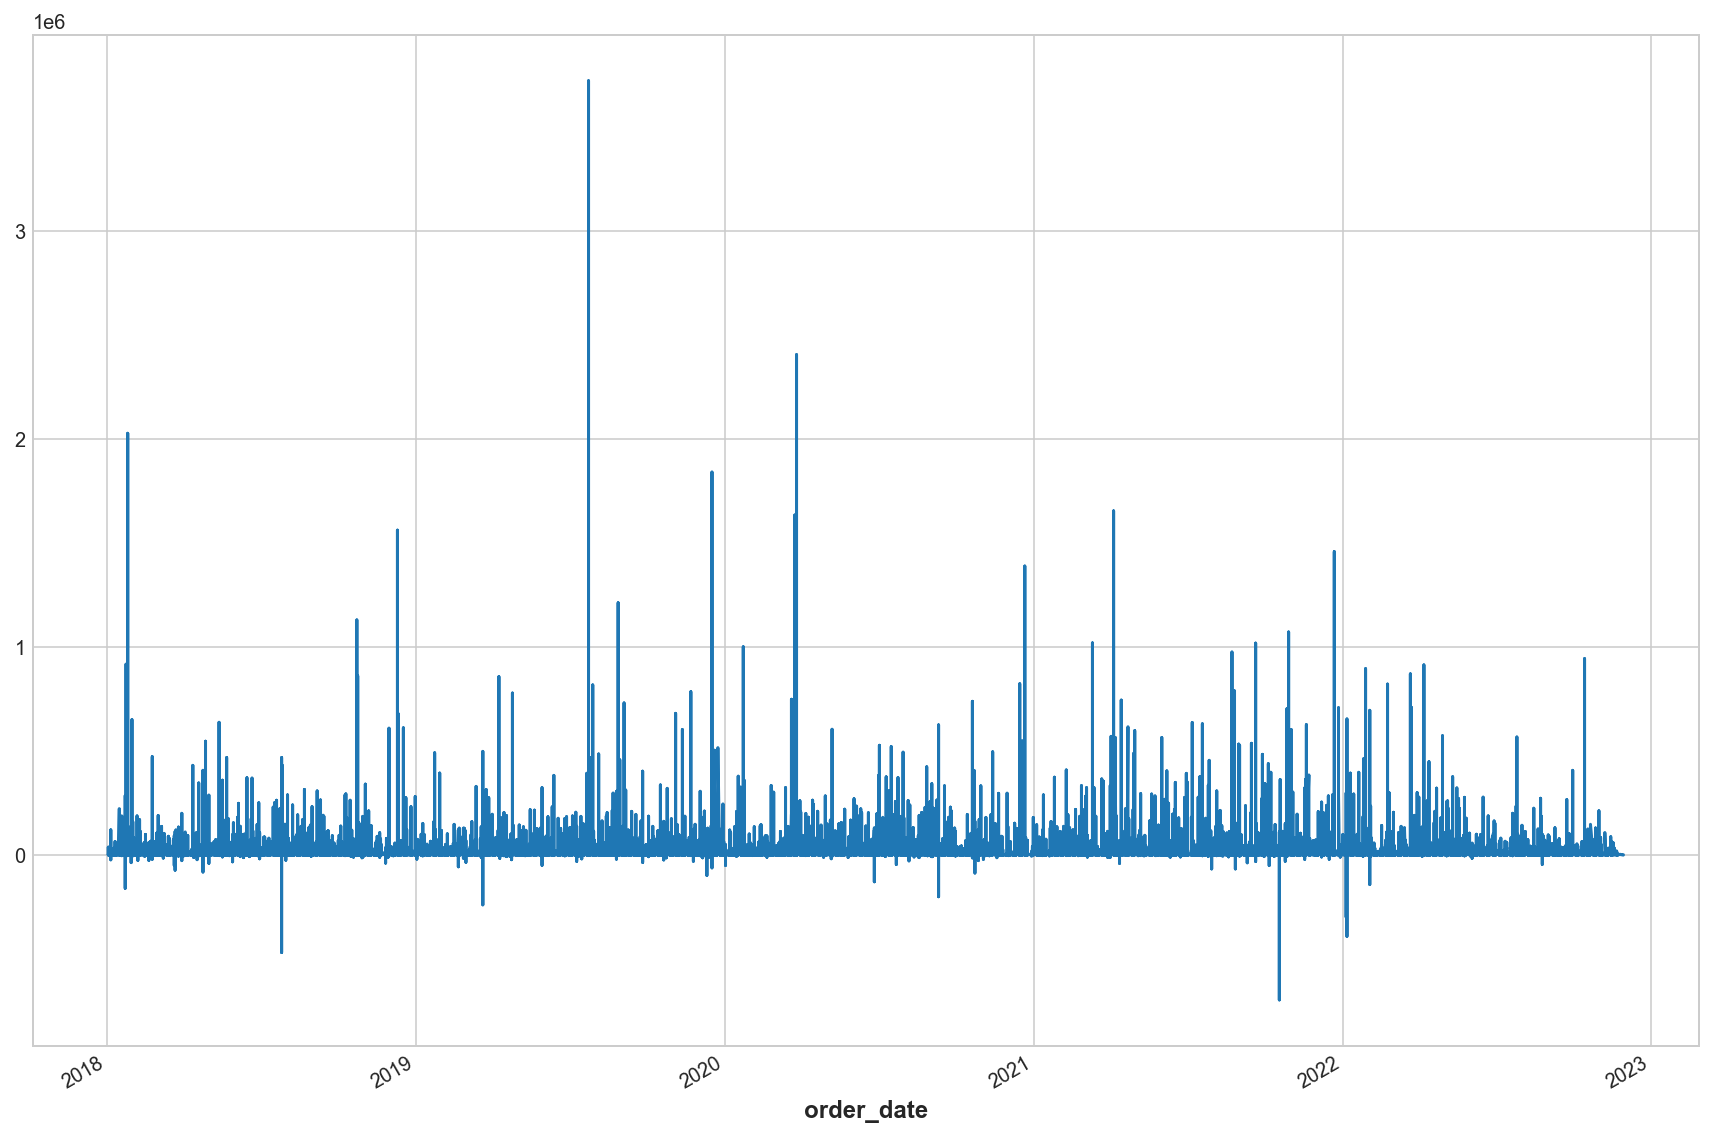

In [47]:
df.purchase_amount.plot(figsize=(12,8))

In [48]:
model_df_weekly= model_df.resample("D").mean()

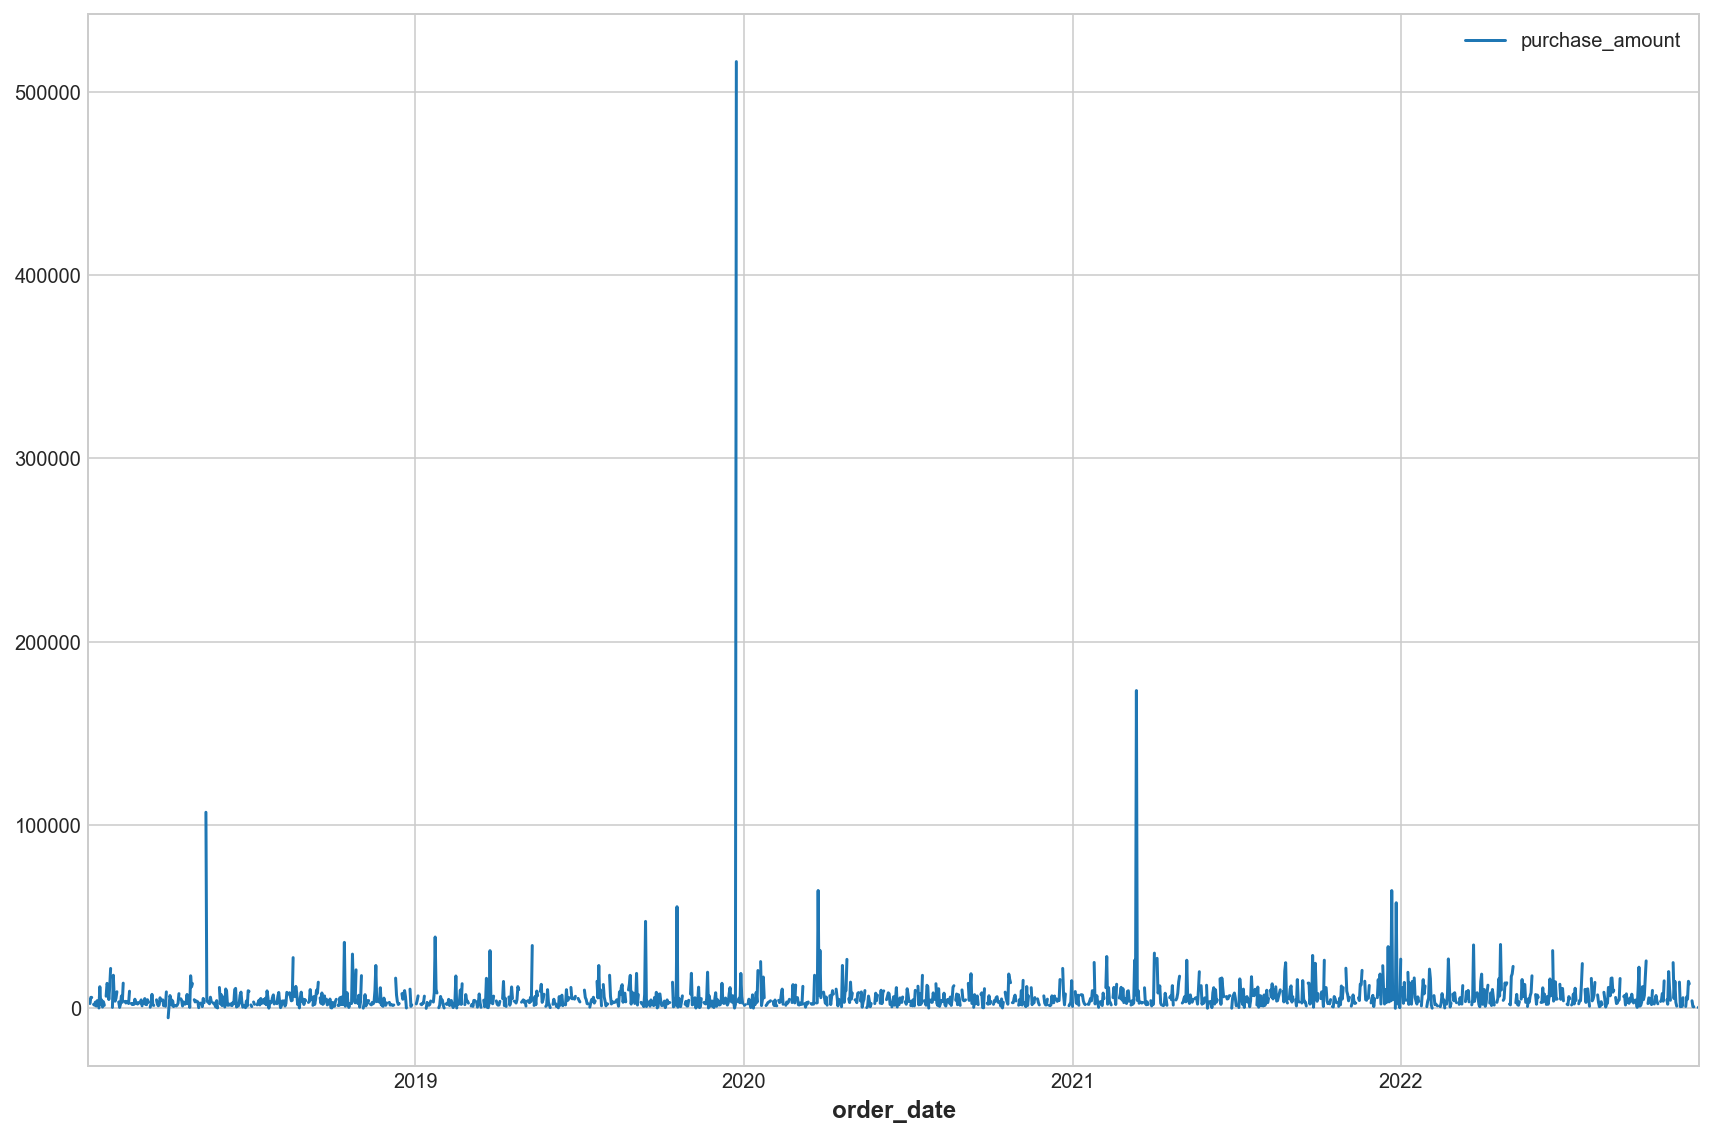

In [49]:
model_df_weekly.plot(figsize=(12,8));

In [50]:
model_df_weekly

,purchase_amount
order_date,
2018-01-02,"5,035.08"
2018-01-03,"3,520.00"
2018-01-04,"2,628.33"
2018-01-05,"6,021.64"
2018-01-06,"5,962.92"
...,...
2022-11-25,"3,178.62"
2022-11-26,NaN
2022-11-27,NaN


In [51]:
model_df_weekly['sale_last_week'] = model_df_weekly['purchase_amount'].shift(1)
model_df_weekly['sale_2weeks_back'] = model_df_weekly.purchase_amount.shift(2)
model_df_weekly['sale_3weeks_back'] = model_df_weekly.purchase_amount.shift(3)

In [52]:
# train
#model_df_weekly[3:-101]
# validate
#model_df_weekly["2021"]
# test
#model_df_weekly[-49:]

In [53]:
model_df_weekly

,purchase_amount,sale_last_week,sale_2weeks_back,sale_3weeks_back
order_date,,,,
2018-01-02,"5,035.08",NaN,NaN,NaN
2018-01-03,"3,520.00","5,035.08",NaN,NaN
2018-01-04,"2,628.33","3,520.00","5,035.08",NaN
2018-01-05,"6,021.64","2,628.33","3,520.00","5,035.08"
2018-01-06,"5,962.92","6,021.64","2,628.33","3,520.00"
...,...,...,...,...
2022-11-25,"3,178.62",NaN,815.31,964.98
2022-11-26,NaN,"3,178.62",NaN,815.31
2022-11-27,NaN,NaN,"3,178.62",NaN


In [54]:
lin_model = LinearRegression()
model = RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=400, random_state=123)

In [57]:
train.shape

(235525, 20)

### split for train test

In [ ]:
x1,x2,x3,y = x1.reshape(-1, 1),  x2.reshape(-1, 1), x3.reshape(-1, 1),y.reshape(-1, 1)

In [ ]:
y=np.array(model_df_weekly.purchase_amount)
x1,x2,x3 = np.array(model_df_weekly.sale_last_week), np.array(model_df_weekly.sale_2weeks_back), np.array(model_df_weekly.sale_3weeks_back)

In [ ]:
final_x = np.concatenate((x1,x2,x3), axis = 1)


In [ ]:
# modeling
X_train, y_train, X_test, y_test = m.modeling_preprocessing(df, columns_to_keep=['customer_type', 'month_name','day_name', 'quarter'], regression=False, np_array=False)

In [ ]:
# cut off all null values start train at index 3
X_train, X_val, X_test, y_train,y_val, y_test = final_x[3:-101],final_x[-101:-49],final_x[-49:], y[3:-101],y[-101:-49],y[-49:]

In [ ]:
X_train

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False).fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
# random Forest
model.fit(X_train, y_train)
# linear regression
lin_model.fit(X_train,y_train)

In [ ]:
pred=model.predict(X_test)
plt.plot(pred, label = 'Random Forest Predictions')
plt.plot(y_test, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# RMSE
rmse_randomforest= sqrt(mean_squared_error(pred, y_test))
rmse_randomforest

In [ ]:
lin_pred=lin_model.predict(X_test)
plt.plot(lin_pred, label = 'Random Forest Predictions')
plt.plot(y_test, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# RMSE
rmse_linear= sqrt(mean_squared_error(lin_pred, y_test))
rmse_linear

### with grid search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)


In [ ]:
best_random = rf_random.best_estimator_

best_random



```python 
RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=800)
```

### find best for linear

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
GBR = GradientBoostingRegressor()

In [ ]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }

In [ ]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [ ]:
grid_GBR_pred=grid_GBR.predict(X_val)
plt.plot(grid_GBR_pred, label = 'Predictions')
plt.plot(y_val, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
rmse_linear= sqrt(mean_squared_error(grid_GBR_pred, y_val))
rmse_linear

In [ ]:
import xgboost
print(xgboost.__version__)